## Avaliação da cidade dos 15 minutos na cidade de Lisboa

In [1]:
%matplotlib inline

import networkx as nx
import osmnx as ox
from IPython.display import IFrame
#from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
#from descartes import PolygonPatch
import pandas as pd
from functools import reduce
import contextily as cx
import itertools
import numpy as np
import subprocess
from multiprocessing import Pool
import os

from tqdm.notebook import tqdm

### Extraçao da rede pedonal

Ferramenta python: https://geoffboeing.com/2016/11/osmnx-python-street-networks/

Notebooks com exemplos: https://github.com/gboeing/osmnx-examples

In [6]:
G = ox.graph_from_place("Lisboa, Lisboa, Portugal", buffer_dist=1500, network_type="walk")

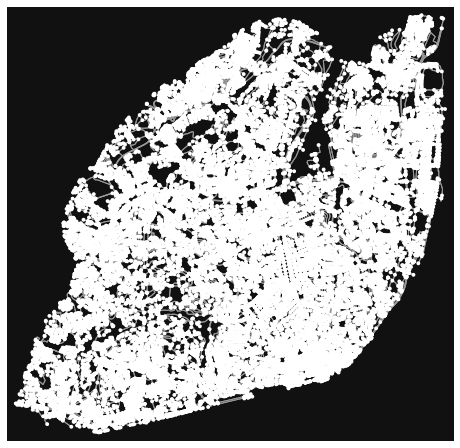

In [7]:
fig, ax = ox.plot_graph(G)

## Acessibilidade a actividades

O conceito da cidade de 15 minutos define que cada pessoa deve poder aceder as várias atividades para o dia a dia. 
*"We calculated the accessibility metric for the following amenity categories: education (schools, universities, etc.), entertainment (indoor places where people pay for access), finance (banks and similar), food (restaurants, bars, cafes, etc.), government facilities, health facilities (hospitals, primary care centers, medical offices, etc.), professional services, recreational areas (parks, outdoors, etc.), religion venues, retail (malls, supermarkets, shopping venues), and public transport (bus stops, metro stations, bike stations, etc.)" (Graells-Garrido et. 2021)"*
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0250080

In [8]:
# add an edge attribute for time in minutes required to traverse each edge
travel_speed = 4.5
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

## Dados dos edifícios

In [10]:
houses2=pd.read_excel("Cubo_202203_NOVAIMS_2022-05-13.xlsx")

In [11]:
houses2.rename(columns={'PRECO_VENDA_OBSERVADO':'PRECO_VENDA'},inplace=True)

In [2]:
lxhouses = houses2.copy()

In [1]:
lxhouses[['COD_POST_4','COD_POS_3']] = lxhouses['CP7'].str.split('-', expand=True)

In [35]:
lxhouses = lxhouses.drop(lxhouses.index[lxhouses['COD_POST_4'] > '1999'])

In [1]:
import geopandas as gpd
lxhouses = gpd.GeoDataFrame(
    lxhouses, geometry=gpd.points_from_xy(lxhouses['LONGITUDE'], lxhouses['LATITUDE']))

In [37]:
gdf_building = gpd.GeoDataFrame(lxhouses, geometry=lxhouses['geometry']).set_crs(epsg=4326)
centroid = gdf_building.to_crs(epsg=3395).centroid.to_crs(epsg=4326)
b_nn = ox.distance.nearest_nodes(G, centroid.x, centroid.y)
gdf_building['node'] = b_nn

## Dados das atividades

In [38]:
amenities = {  # tags do OSM
    'government': {"amenity": ["courthouse", "fire_station", "police", "post_office", "townhall"]},
    'food': {"amenity": ["bar", "biergarten", "cafe", "fast_food", "food_court", "ice_cream","pub","restaurant"]},
    'finance': {"amenity": ['bank']},
    'leisure': {"leisure": ["garden", "marina", "park", "playground", "swimming_area", "swimming_pool", "water_park"]},
    'entertainment': {"amenity": ["arts_centre", "casino", "cinema", "community_centre", "conference_centre", "events_venue", "gambling", "nightclub", "planetarium", "public_bookcase", "social_centre","theatre"]},
    'public_transport': {"public_transport": True},
    'education': {"amenity": ["college", "kindergarten", "school", "university"]},
    'health': {"amenity": ["clinic", "dentist", "doctors", "hospital", "pharmacy"]}
}

In [39]:
def load_amenity(amenity_dict, name):
    amenity = ox.geometries_from_place("Lisboa, Lisboa, Portugal", amenity_dict, buffer_dist=1500).reset_index()[['osmid', 'amenity', 'name', 'geometry']]
    amenity['type'] = name

    gdf_amenity = gpd.GeoDataFrame(amenity, geometry=amenity['geometry']).set_crs(epsg=4326)
    centroids = gdf_amenity.to_crs(epsg=3395).centroid.to_crs(epsg=4326)
    gdf_amenity['node'] = ox.distance.nearest_nodes(G, centroids.x, centroids.y)
    return gdf_amenity

In [40]:
gdf_amenity = gpd.GeoDataFrame(columns=['osmid', 'amenity', 'name', 'geometry', 'type', 'node']).set_crs(epsg=4326)

for key in amenities.keys():
    gdf_amenity = gdf_amenity.append(load_amenity(amenities[key], key))

/home/jupyter-bjardim/.local/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/home/jupyter-bjardim/.local/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/home/jupyter-bjardim/.local/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

In [22]:
gdf_node_amenity = gdf_amenity[['node','geometry']].drop_duplicates(subset='node')
gdf_node_amenity.head()

,node,geometry
0,4392369874,POINT (-9.16792 38.76113)
1,268332116,POINT (-9.16376 38.79869)
2,268140067,POINT (-9.16583 38.79817)
3,1163868609,POINT (-9.14983 38.73136)
4,431908069,POINT (-9.20609 38.73327)


In [2]:
gdf_node_building = gdf_building[['node','geometry']].drop_duplicates(subset='node')

# Calculating the distances in between Buildings and Amenities

In [ ]:
point_euclidean_distance_amenity = gpd.GeoDataFrame(columns=['im_node', 'am_node', 'euclidean_distance'])
am_geometry = gdf_node_amenity.to_crs(epsg=3395)
point_geometry = gdf_node_building.to_crs(epsg=3395)
for index, row in tqdm(pd.DataFrame(am_geometry).iterrows(), total=len(am_geometry)):
    temp_gdf = point_geometry[['node', 'geometry']].copy(deep=True)
    temp_gdf['euclidean_distance'] = temp_gdf.geometry.distance(row.geometry)
    temp_gdf = temp_gdf.loc[temp_gdf.euclidean_distance <= 1500]
    temp_gdf['node_am'] = row.node                                                   
    #df_distances.to_csv('03_nodes_network_distance.csv', index=0, header=0, mode='a')
    point_euclidean_distance_amenity = point_euclidean_distance_amenity.append(temp_gdf, ignore_index=True)

  0%|          | 0/7110 [00:00<?, ?it/s]

In [ ]:
point_euclidean_distance_amenity = point_euclidean_distance_amenity.drop(columns=['geometry'], axis=1)

In [30]:
point_euclidean_distance_amenity.head()

,im_node,am_node,euclidean_distance,node,node_am
0,NaN,NaN,1430.051479,7.733745e+09,4.392370e+09
1,NaN,NaN,776.969193,1.350945e+09,4.392370e+09
2,NaN,NaN,1290.471957,6.599945e+08,4.392370e+09
3,NaN,NaN,1362.821498,9.258624e+09,4.392370e+09
4,NaN,NaN,1249.489105,2.692773e+08,4.392370e+09


In [32]:
point_euclidean_distance_amenity = point_euclidean_distance_amenity[['node', 'node_am', 'euclidean_distance']]

In [ ]:
point_euclidean_distance_amenity.to_csv('building_am_euclidean.csv', index=False)

In [49]:
# add an edge attribute for time in minutes required to traverse each edge
travel_speed = 4.5
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [57]:
def multi_get_distances2(indexes):

    index_o, index_d = indexes
    distance = nx.shortest_path_length(G, index_o, index_d, weight='time')
    df_distances = pd.DataFrame([[index_o, index_d, distance]], columns=['index_o', 'index_d', 'distance'])
    df_distances = df_distances[df_distances['distance']<=15]
    df_distances.to_csv('building_amenities_network_distance.csv', index=0, header=0, mode='a')
    #print(df_distances)

In [ ]:
from tqdm.notebook import tqdm
pd.DataFrame(columns=['index_o', 'index_d', 'distance']).to_csv('building_amenities_network_distance.csv', index=0)

for index, row in tqdm(point_euclidean_distance_amenity.iterrows(), total=len(point_euclidean_distance_amenity)):
    pair = [row.node, row.node_am]
    multi_get_distances2(pair)

  0%|          | 0/1636794 [00:00<?, ?it/s]

In [10]:
df_distances = pd.read_csv('building_amenities_network_distance.csv')
df_distances.head()

,index_o,index_d,distance
0,2488591511,5543500030,9.452800
1,2488591511,9824112797,13.488973
2,2488591511,1645267837,11.751973
3,2488591511,2386988535,12.076000
4,2488591511,484619197,12.179613
